# Probabilistic machine learning
## Deep learning multi-model ensemble

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from scipy.stats import norm

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Usecase: linear RUL

**Define the data function and parameter limits**

In [2]:
# Define linear function
def func(x, a, c, noise_amp = 0):
    y = a*x + c
    y = y + noise_amp * np.random.randn(len(x))
    return y

# Set parameter limits
x = np.arange(0,10,0.1)
a_range = (0, 2)
c_range = (0, 10)
noise_range = (0,5)

**Create at deep learning model architecture**

In [3]:
def create_model(input_shape=100, output_shape=2):
    model = Sequential()
    model.add(Dense(64, input_dim=100, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [4]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 9,106
Trainable params: 9,106
Non-trainable params: 0
_________________________________________________________________


2024-11-06 16:43:41.731591: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-06 16:43:41.731724: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (GTCWK05): /proc/driver/nvidia/version does not exist
2024-11-06 16:43:41.734547: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Train the model

n_regessors = 100
n_training_obs = 1000
regressors = []
np.random.seed(2049)

for n in tqdm(range(n_regessors)):

    a_list = np.random.rand(n_training_obs)*(a_range[1] - a_range[0]) + a_range[0]
    c_list = np.random.rand(n_training_obs)*(c_range[1] - c_range[0]) + c_range[0]
    noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]

    targets = np.array(list(zip(a_list,c_list)))
    targets_with_noise = np.array(list(zip(a_list,c_list,noise_list)))
    features = np.array([func(x,a,c,noise) for a, c, noise in targets_with_noise])

    reg = create_model()
    reg.fit(features, targets, epochs=50, batch_size=32, verbose=0)
    regressors.append(reg)

print('Done')

100%|████████████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]

Done


In [7]:
a_list = np.random.rand(n_training_obs)*(a_range[1] - a_range[0]) + a_range[0]
c_list = np.random.rand(n_training_obs)*(c_range[1] - c_range[0]) + c_range[0]
noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]

targets = np.array(list(zip(a_list,c_list)))
targets_with_noise = np.array(list(zip(a_list,c_list,noise_list)))
features = np.array([func(x,a,c,noise) for a, c, noise in targets_with_noise])

a_pred = []
c_pred = []

for reg in tqdm(regressors):
    result = reg.predict(features)
    a, c = result.T
    a_pred.append(a)
    c_pred.append(c)

a_pred = np.array(a_pred).T
c_pred = np.array(c_pred).T

a_mean = a_pred.mean(axis=1)
c_mean = c_pred.mean(axis=1)

100%|████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.83it/s]


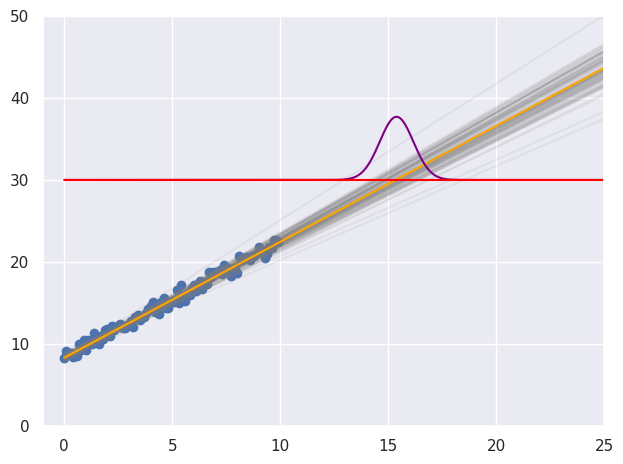

In [12]:
idx = 3

limit = 30
x30 = np.arange(0,30,0.1)
rul_list = []

for idx_reg in range(n_regessors):
    y_pred_idx = func(x30, a_pred[idx][idx_reg], c_pred[idx][idx_reg])
    plt.plot(x30, y_pred_idx, color='grey', alpha=0.1)
    idx_rul = np.abs(y_pred_idx - limit).argmin()
    rul = x30[idx_rul]
    rul_list.append(rul)

y_pred_mean = func(x30, a_mean[idx], c_mean[idx])
plt.plot(x30, y_pred_mean, color='orange')

rul_list = np.array(rul_list)
rul_mean = rul_list.mean()
rul_std = rul_list.std()
rul_pdf = norm.pdf(x30, rul_mean, rul_std)
plt.plot(x30, (rul_pdf*15)+30, color='purple')

plt.hlines(limit, 0, 30, color='red')
plt.scatter(x, features[idx])

plt.xlim(-1,25)
plt.ylim(0,50)
plt.tight_layout()
plt.savefig('images/3.1 sample obs.png', dpi=150)
plt.show()

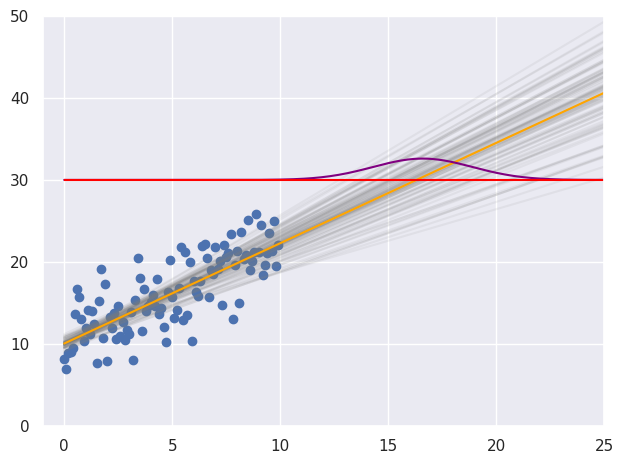

In [15]:
idx = 6

limit = 30
x30 = np.arange(0,30,0.1)
rul_list = []

for idx_reg in range(n_regessors):
    y_pred_idx = func(x30, a_pred[idx][idx_reg], c_pred[idx][idx_reg])
    plt.plot(x30, y_pred_idx, color='grey', alpha=0.1)
    idx_rul = np.abs(y_pred_idx - limit).argmin()
    rul = x30[idx_rul]
    rul_list.append(rul)

y_pred_mean = func(x30, a_mean[idx], c_mean[idx])
plt.plot(x30, y_pred_mean, color='orange')

rul_list = np.array(rul_list)
rul_mean = rul_list.mean()
rul_std = rul_list.std()
rul_pdf = norm.pdf(x30, rul_mean, rul_std)
plt.plot(x30, (rul_pdf*15)+30, color='purple')

plt.hlines(limit, 0, 30, color='red')
plt.scatter(x, features[idx])

plt.xlim(-1,25)
plt.ylim(0,50)
plt.tight_layout()
plt.savefig('images/3.2 sample obs.png', dpi=150)
plt.show()

**Correlate std to error**

In [16]:
rul_true_list = []
rul_mean_list = []
rul_std_list = []
x100 = np.arange(0, 100, 0.1)
limit = 30

for idx, a in tqdm(enumerate(a_list)):
    # Find the true RUL
    c = c_list[idx]
    y_true = func(x100, a, c)
    rul_true = x100[np.abs(y_true - limit).argmin()]
    rul_true_list.append(rul_true)

    # Calculate the probabilitic 
    rul_discrete_dist = []
    for idx_reg in range(n_regessors):
        y_pred_idx = func(x100, a_pred[idx][idx_reg], c_pred[idx][idx_reg])
        idx_rul = np.abs(y_pred_idx - limit).argmin()
        rul = x100[idx_rul]
        rul_discrete_dist.append(rul)
    
    rul_mean_list.append(np.mean(rul_discrete_dist))
    rul_std_list.append(np.std(rul_discrete_dist))

1000it [00:04, 238.35it/s]


In [17]:
data = {'noise':noise_list, 'rul_true':rul_true_list, 'rul_pred_mean':rul_mean_list, 'rul_pred_std':rul_std_list}
df = pd.DataFrame(data)
df['rul_pred_error'] = df.rul_pred_mean - df.rul_true
df['rul_pred_error_abs'] = df.rul_pred_error.abs()

# remove ruls that are very far in the future
df = df.loc[df.rul_true <= 80, :]
df.reset_index(drop=True, inplace=True)

df

noise  rul_true  rul_pred_mean  rul_pred_std  rul_pred_error  \
0    4.388930      20.3         20.016      5.957646          -0.284   
1    4.558305      44.0         42.661     22.603136          -1.339   
2    3.478432      24.3         28.389     11.748080           4.089   
3    0.525154      15.1         15.382      0.775936           0.282   
4    0.995105      25.4         25.364      1.924397          -0.036   
..        ...       ...            ...           ...             ...   
845  3.625023      36.9         51.778     21.991001          14.878   
846  4.159900      66.8         48.689     22.474852         -18.111   
847  2.983886      15.2         14.932      1.465120          -0.268   
848  3.746775      14.9         14.778      2.054584          -0.122   
849  1.787454      20.0         19.286      1.621975          -0.714   

     rul_pred_error_abs  
0                 0.284  
1                 1.339  
2                 4.089  
3                 0.282  
4                 0.036  
..                  ...  
845              14.878  
846              18.111  
847               0.268  
848               0.122  
849               0.714  

[850 rows x 6 columns]

/tmp/ipykernel_4349/3260828568.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = plt.colorbar(label='Noise')


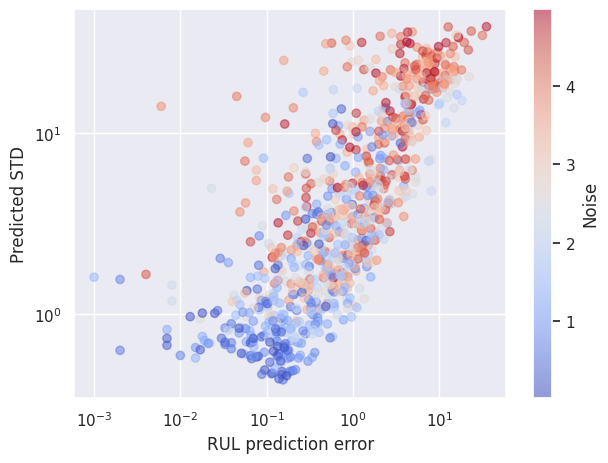

In [20]:
x = df.rul_pred_error_abs
y = df.rul_pred_std
z = df.noise
plt.scatter(x, y, c=z, cmap='coolwarm', alpha=0.5)
colorbar = plt.colorbar(label='Noise')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('RUL prediction error')
plt.ylabel('Predicted STD')
plt.tight_layout()
plt.savefig('images/3.3 std_error.png', dpi=150)
plt.show()

**Visualizing STD with inclreased noise**

In [36]:
noise_list = np.arange(0, 5.1, 0.1)
a_list = np.ones(len(noise_list)) * 1.3
c_list = np.ones(len(noise_list)) * 8.6
x = np.arange(0,10,0.1)


targets = np.array(list(zip(a_list,c_list)))
targets_with_noise = np.array(list(zip(a_list,c_list,noise_list)))
features = np.array([func(x,a,c,noise) for a, c, noise in targets_with_noise])

a_pred = []
c_pred = []

for reg in tqdm(regressors):
    result = reg.predict(features)
    a, c = result.T
    a_pred.append(a)
    c_pred.append(c)

a_pred = np.array(a_pred).T
c_pred = np.array(c_pred).T

a_mean = a_pred.mean(axis=1)
c_mean = c_pred.mean(axis=1)

100%|████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.36it/s]


In [48]:
# Find the true RUL
y_true = func(x100, 1.3, 8.6)
rul_true = x100[np.abs(y_true - limit).argmin()]
rul_true

16.5

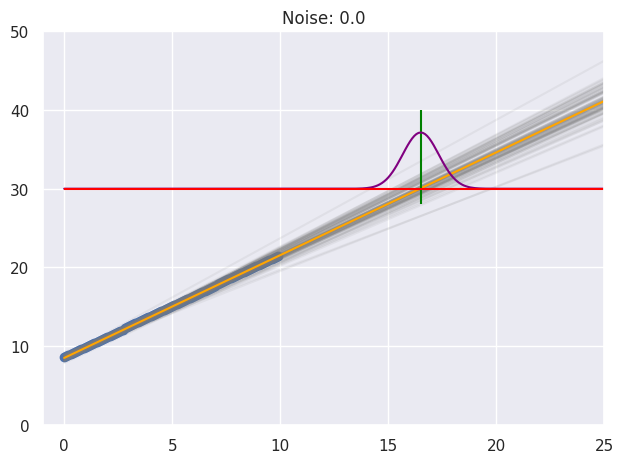

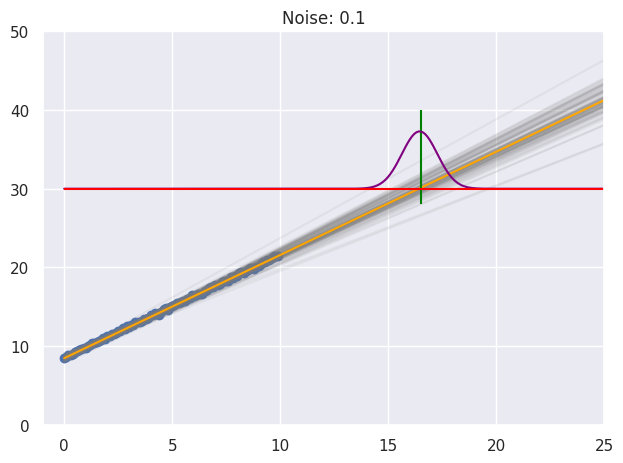

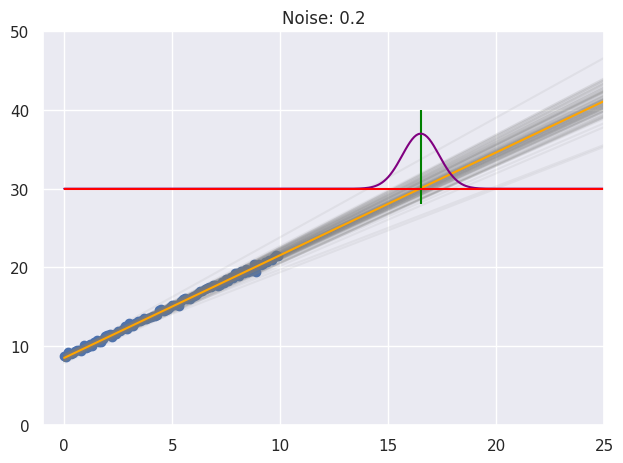

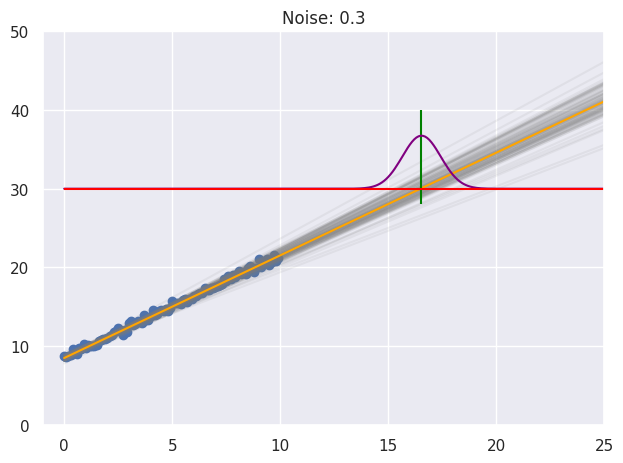

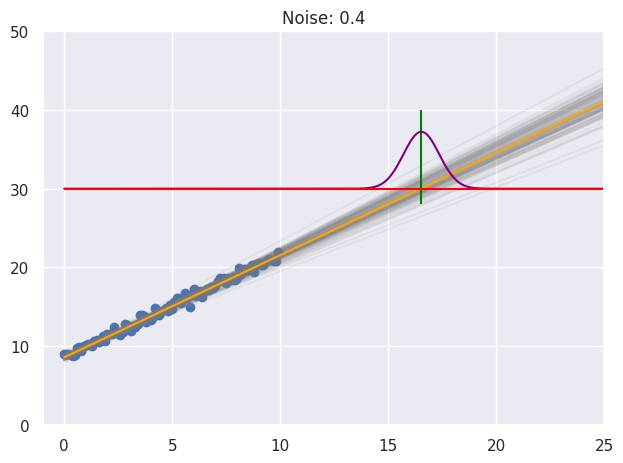

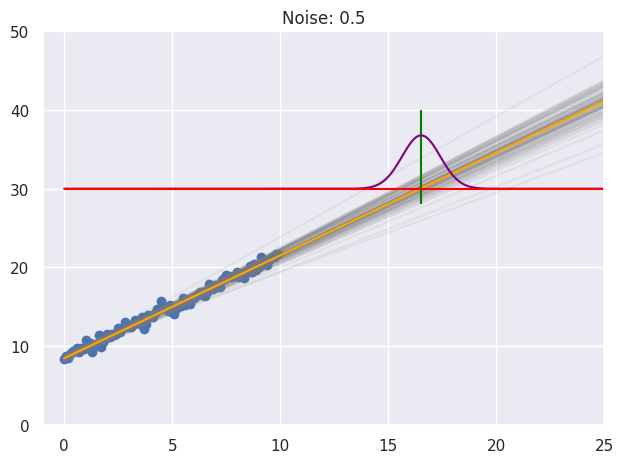

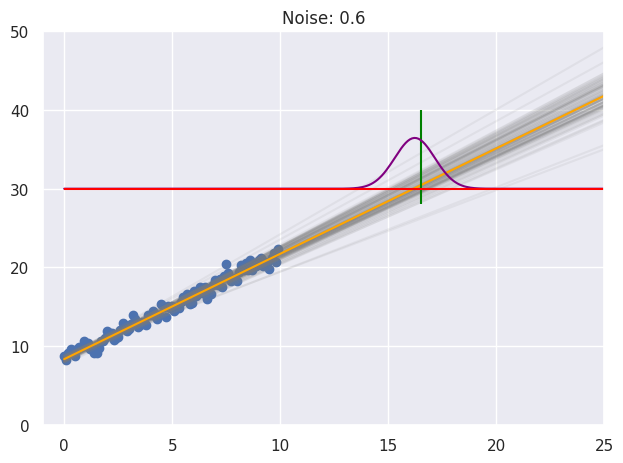

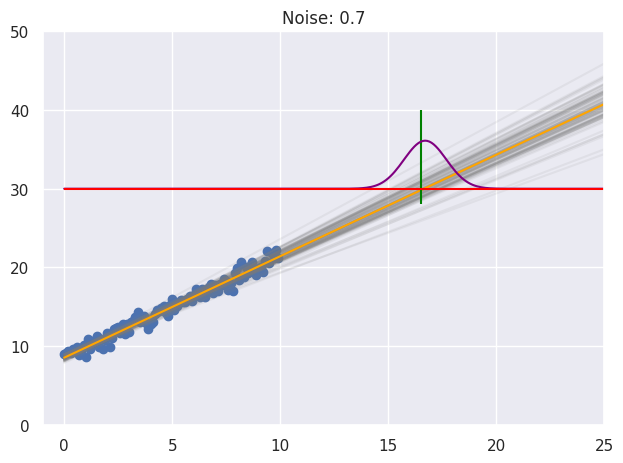

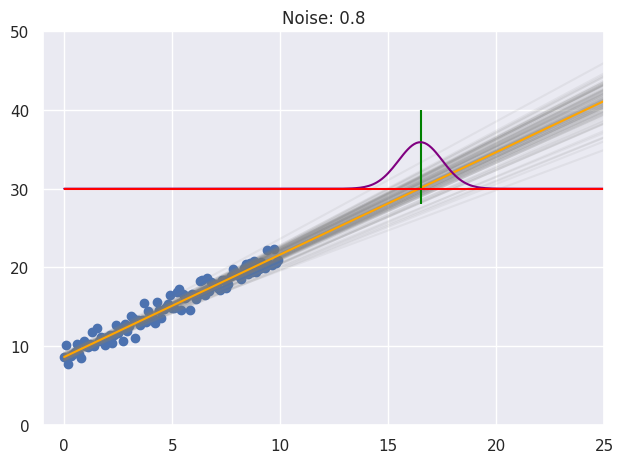

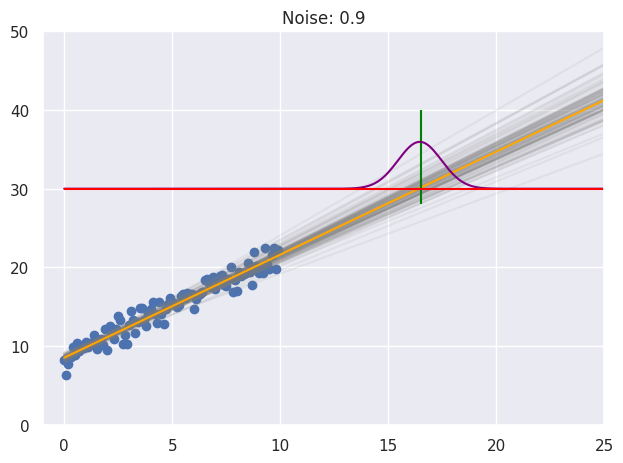

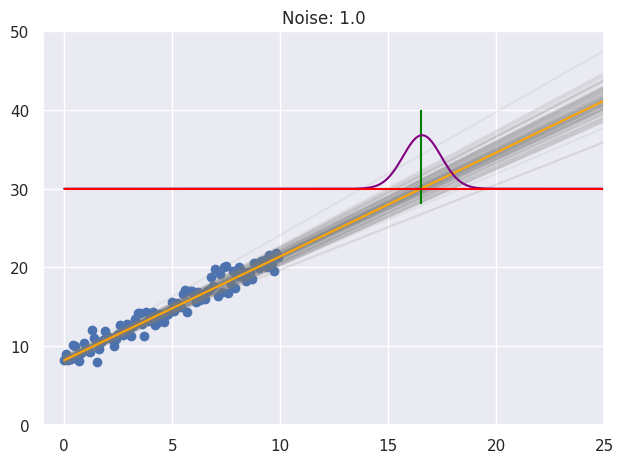

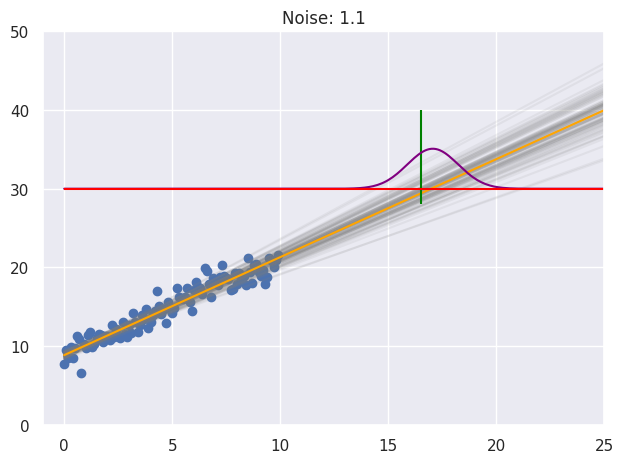

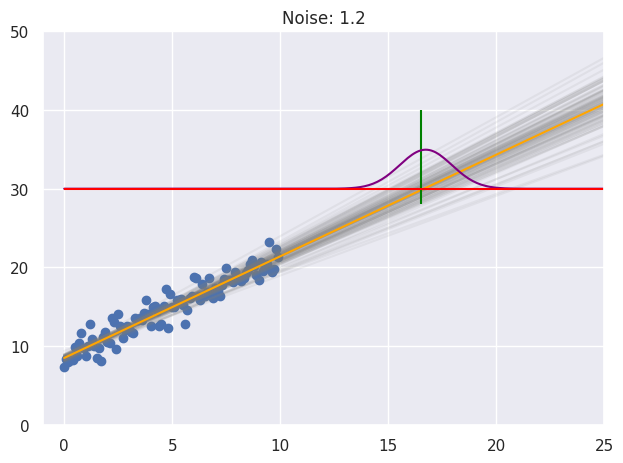

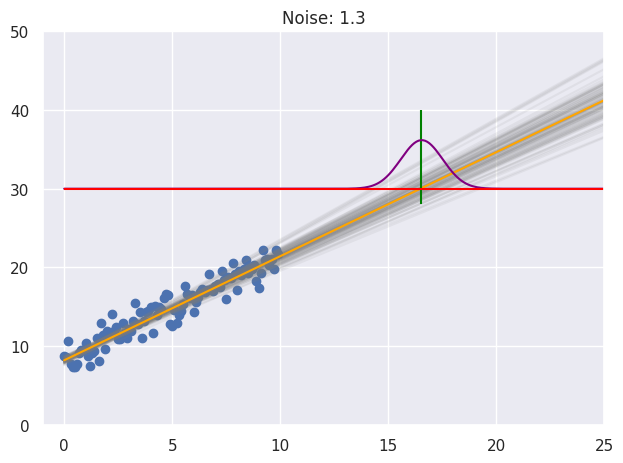

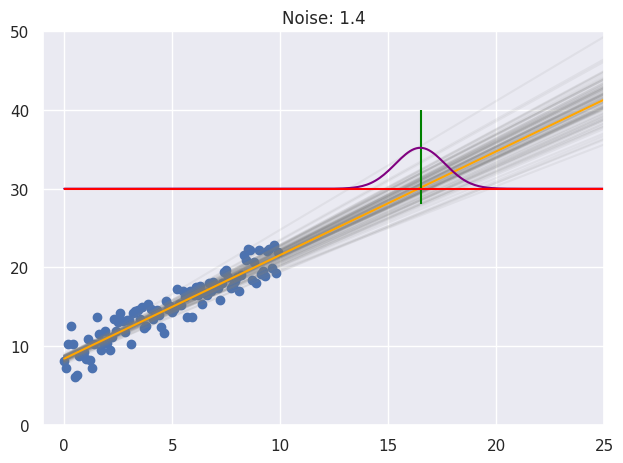

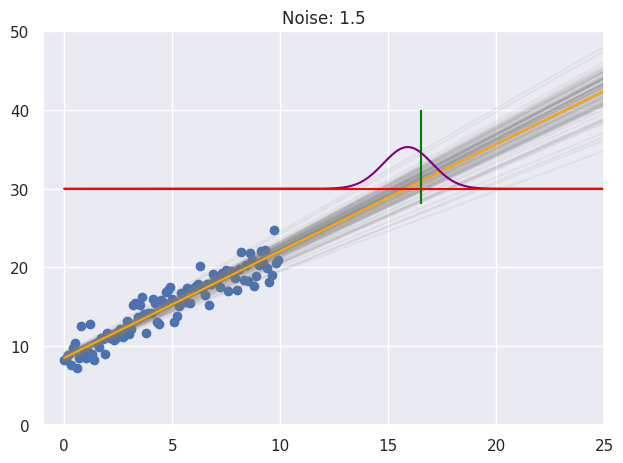

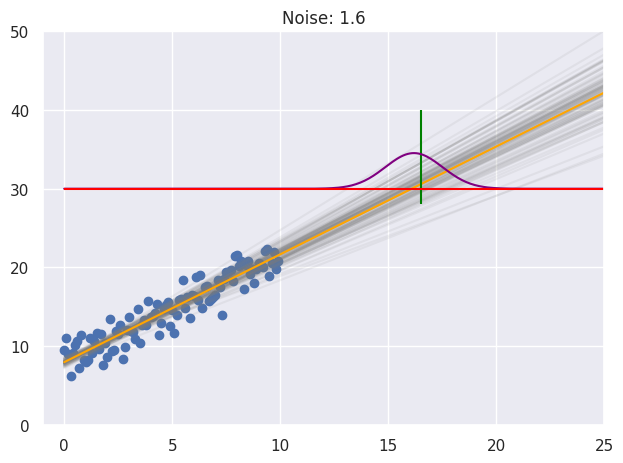

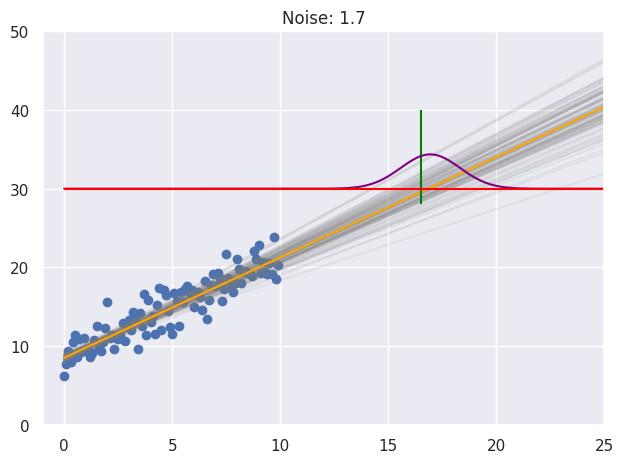

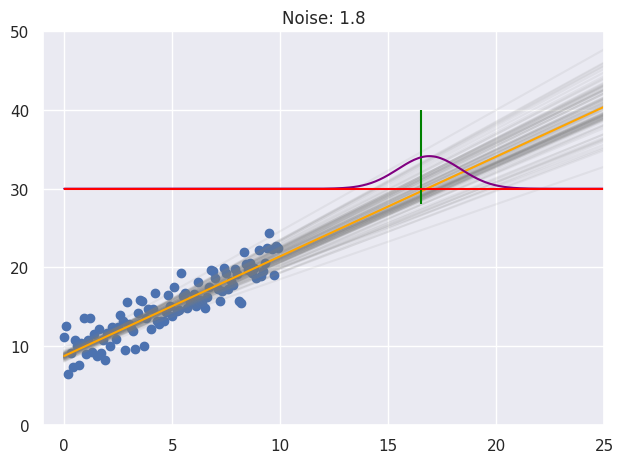

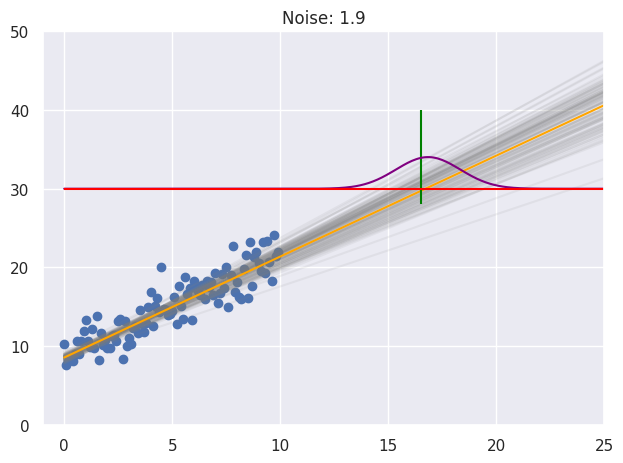

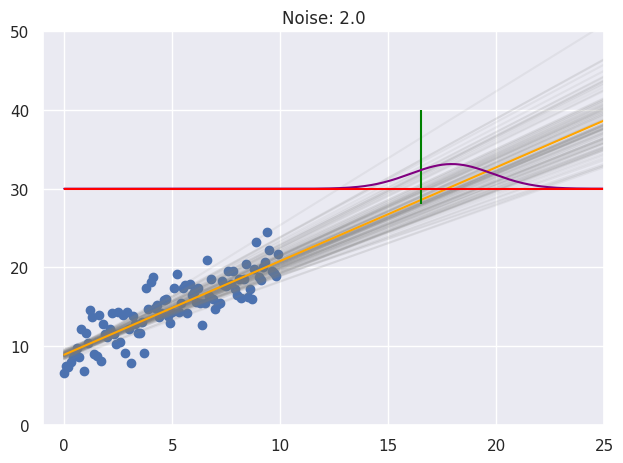

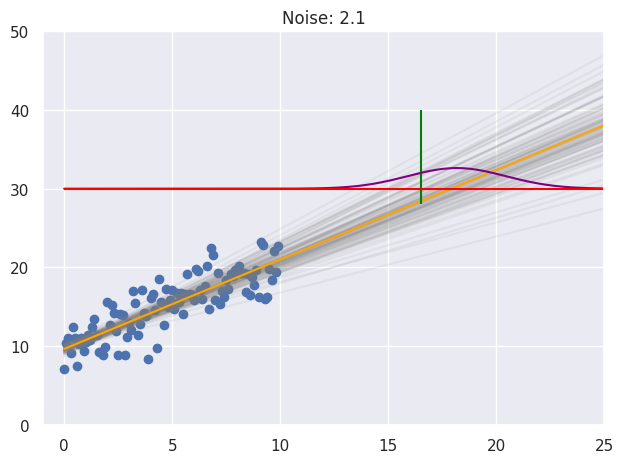

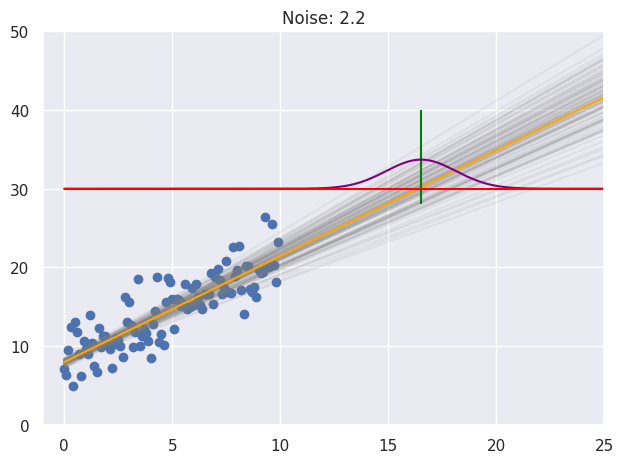

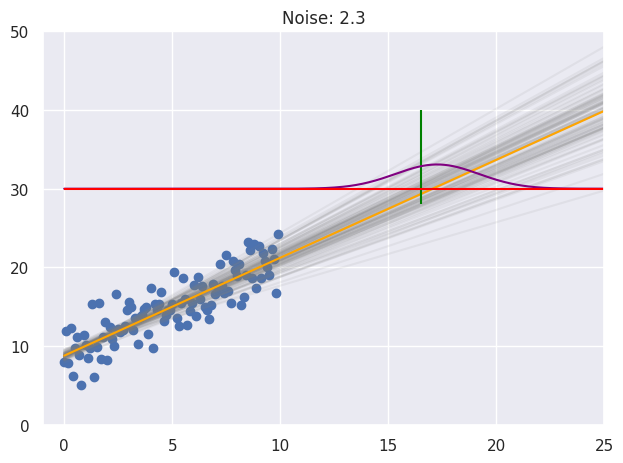

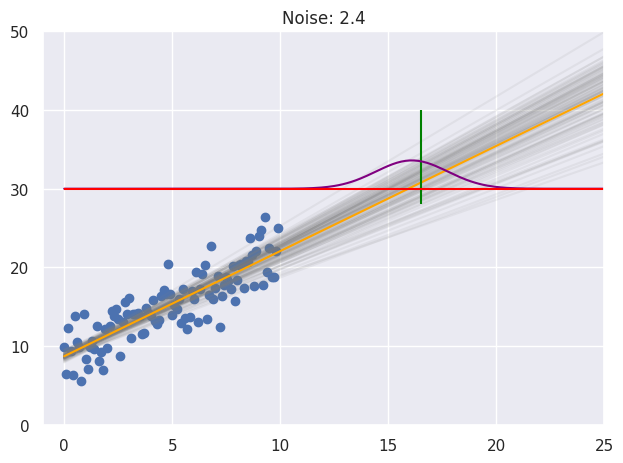

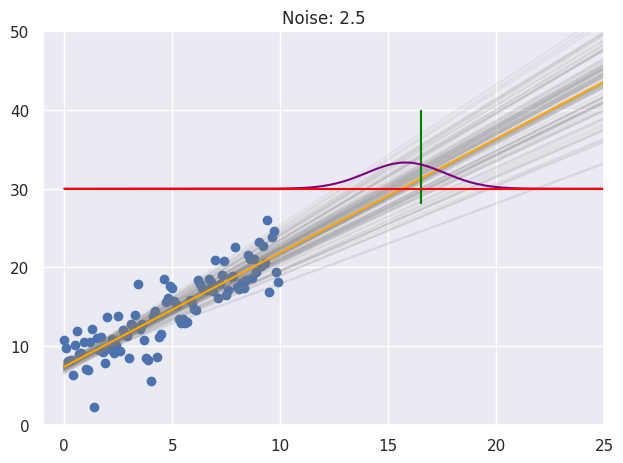

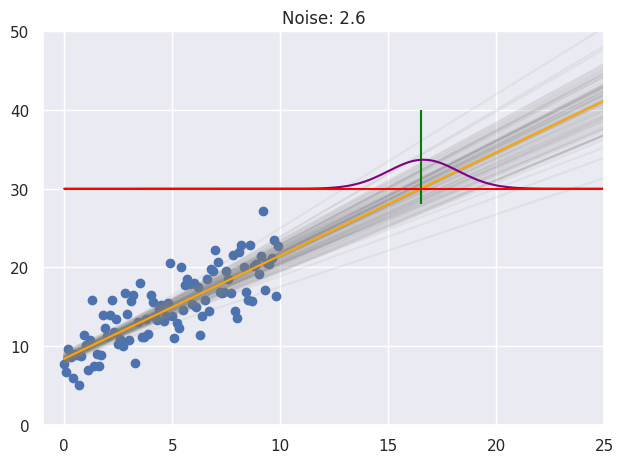

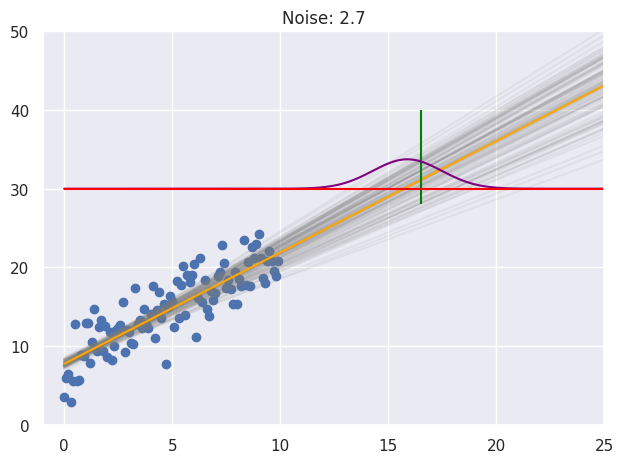

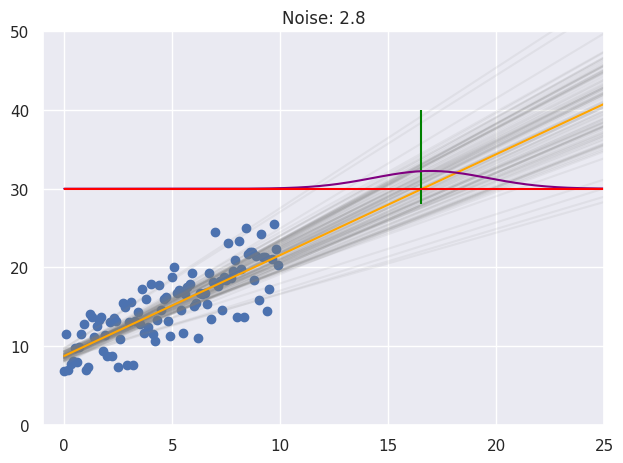

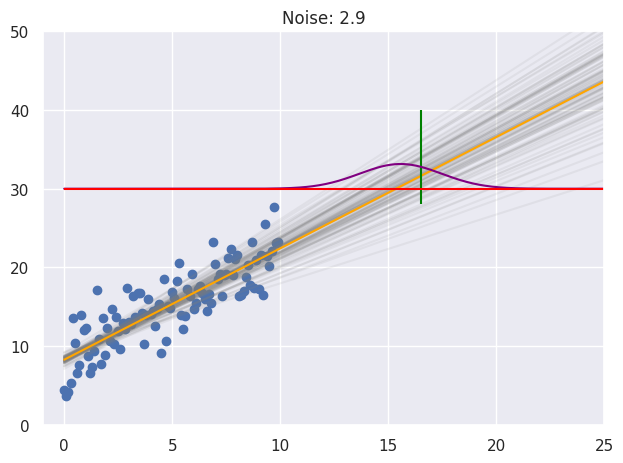

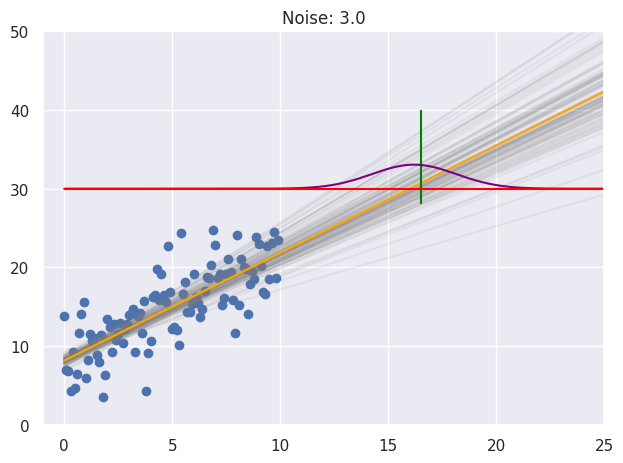

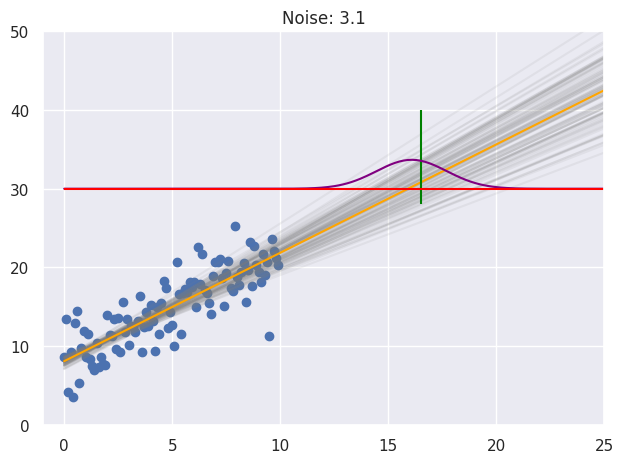

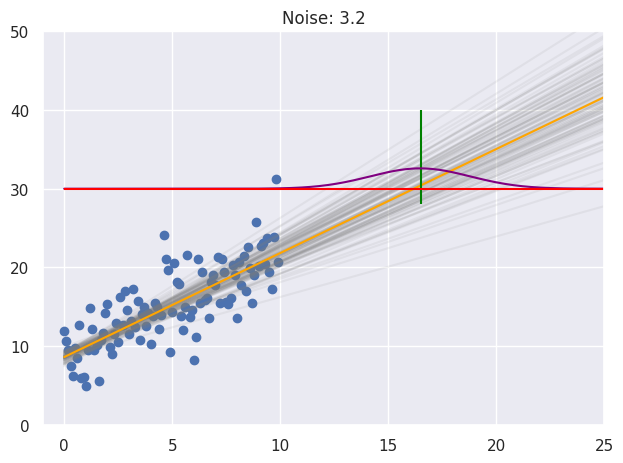

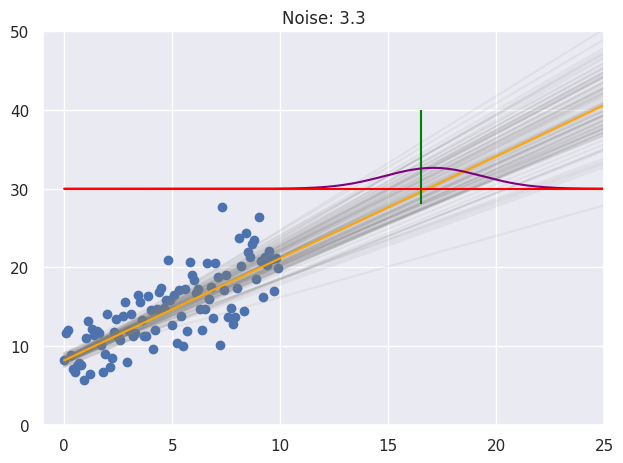

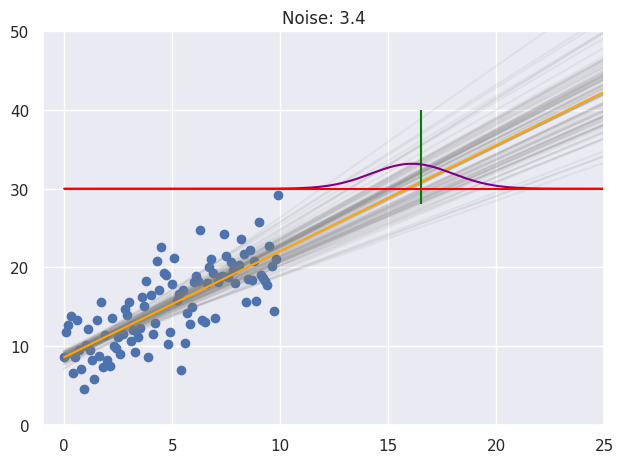

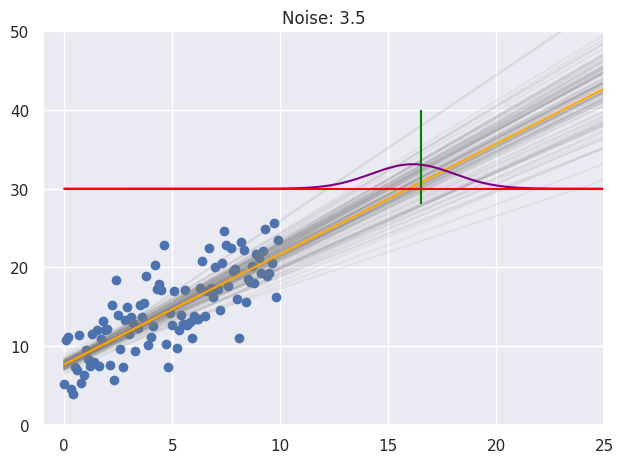

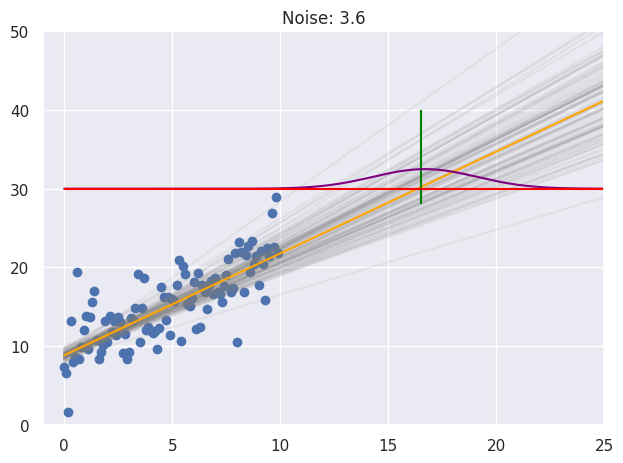

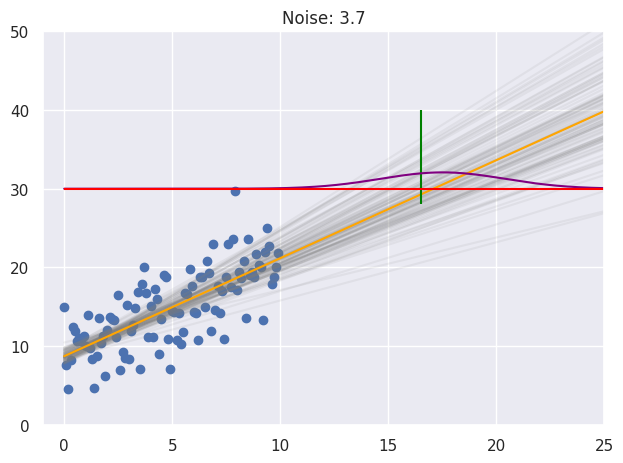

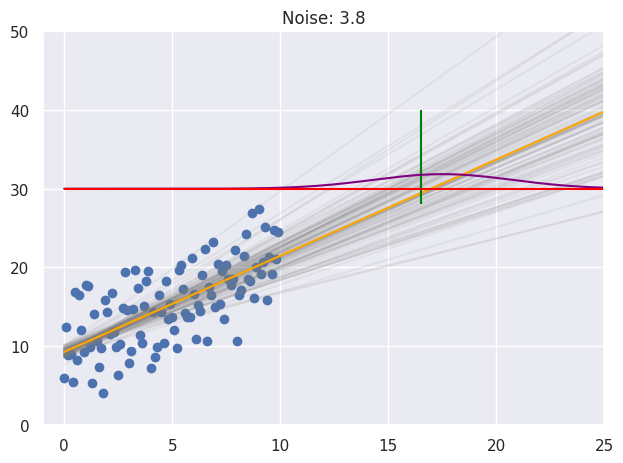

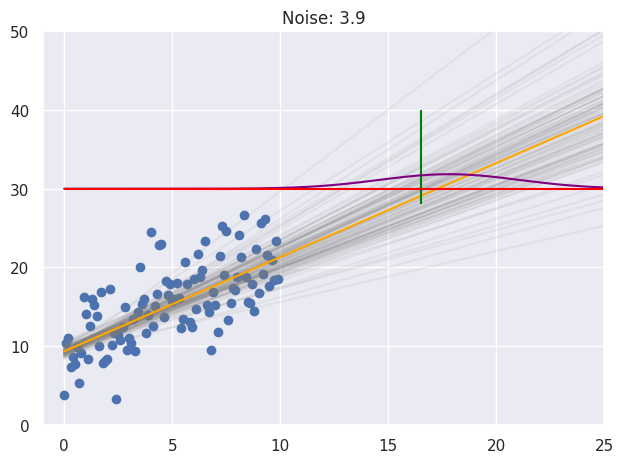

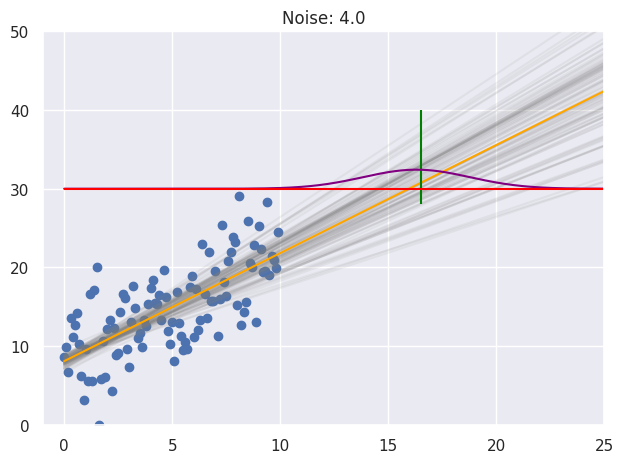

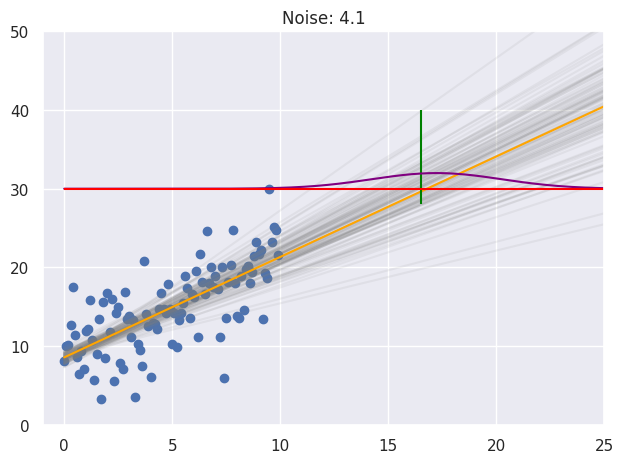

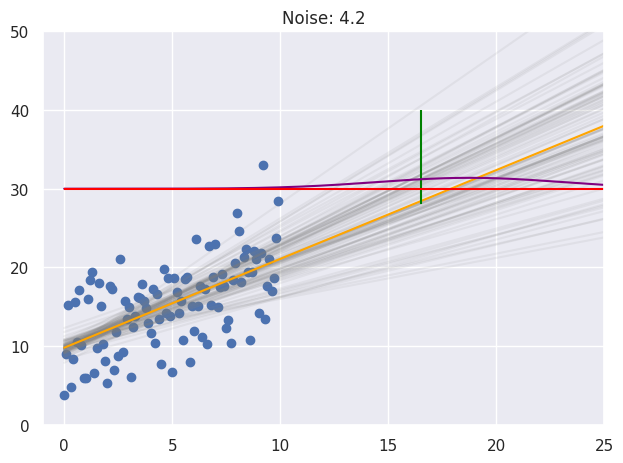

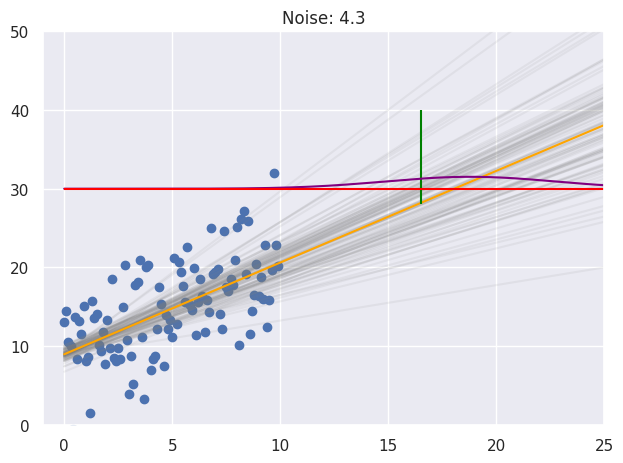

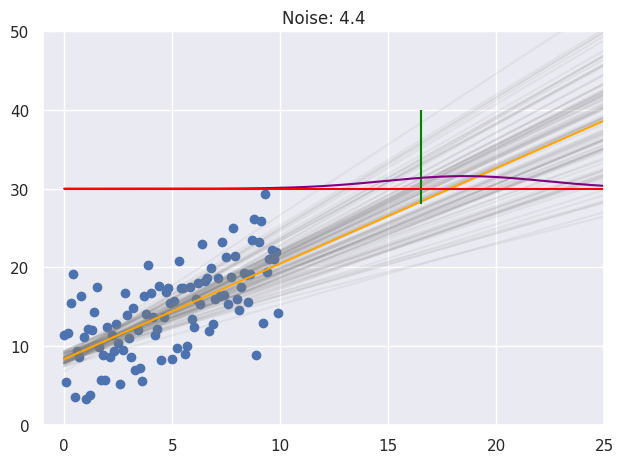

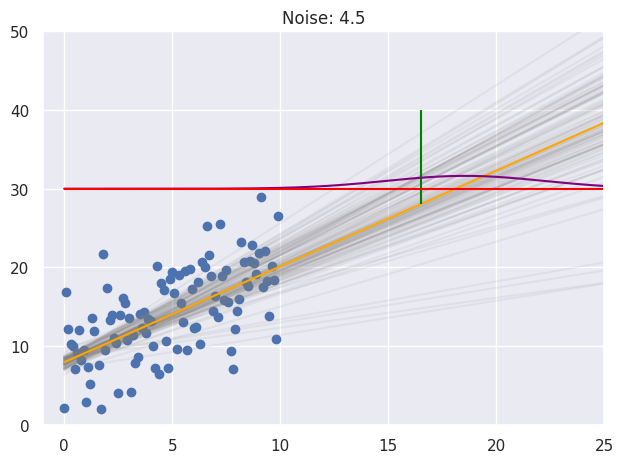

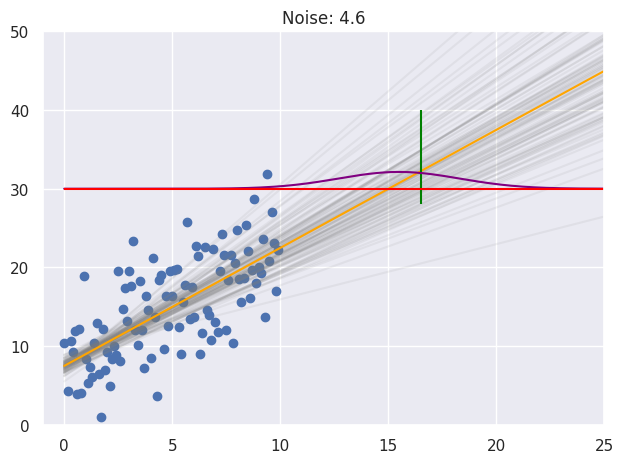

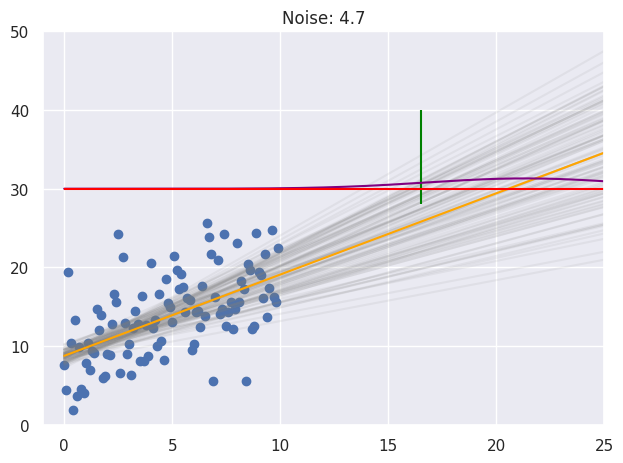

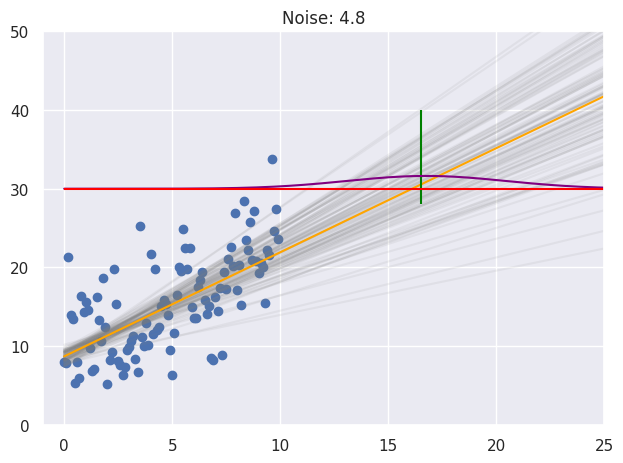

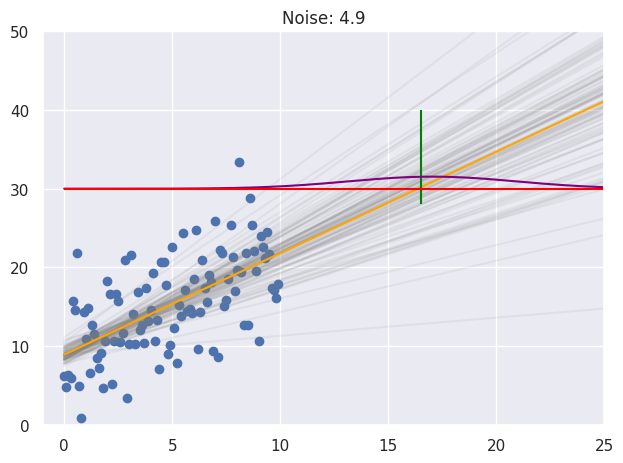

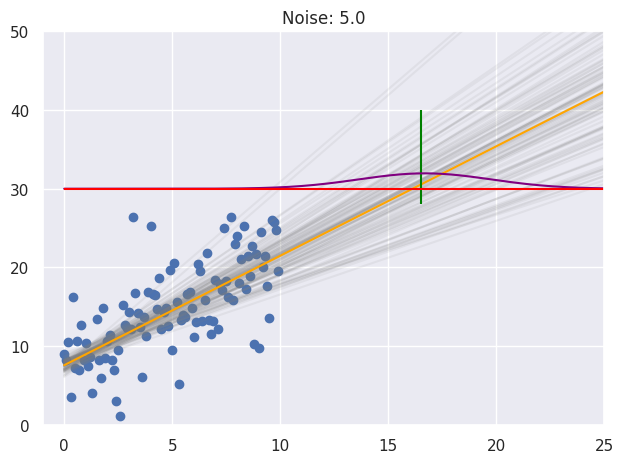

In [50]:
idx = 20

for idx in range(len(noise_list)):

    limit = 30
    x30 = np.arange(0,30,0.1)
    rul_list = []
    
    for idx_reg in range(n_regessors):
        y_pred_idx = func(x30, a_pred[idx][idx_reg], c_pred[idx][idx_reg])
        plt.plot(x30, y_pred_idx, color='grey', alpha=0.1)
        idx_rul = np.abs(y_pred_idx - limit).argmin()
        rul = x30[idx_rul]
        rul_list.append(rul)
    
    y_pred_mean = func(x30, a_mean[idx], c_mean[idx])
    plt.plot(x30, y_pred_mean, color='orange')

    plt.vlines(rul_true, 28, 40, color='green')
    
    rul_list = np.array(rul_list)
    rul_mean = rul_list.mean()
    rul_std = rul_list.std()
    rul_pdf = norm.pdf(x30, rul_mean, rul_std)
    plt.plot(x30, (rul_pdf*15)+30, color='purple')
    
    plt.hlines(limit, 0, 30, color='red')
    plt.scatter(x, features[idx])
    
    plt.title('Noise: {}'.format(round(noise_list[idx],1)))
    plt.xlim(-1,25)
    plt.ylim(0,50)
    plt.tight_layout()
    plt.savefig('images/gif1/1sample_obs{:02d}.png'.format(idx), dpi=150)
    plt.show()

In [51]:
from glob import glob
from PIL import Image

image_files = np.array(glob('images/gif1/*.png'))
image_files.sort()

output_gif = 'images/1sample.gif'

# Open images and create a GIF
frames = [Image.open(image) for image in image_files]

# Save the frames as a GIF
frames[0].save(
    output_gif, 
    format='GIF', 
    save_all=True, 
    append_images=frames[1:], 
    duration=200,  # Duration in milliseconds between frames
    loop=0  # 0 means infinite loop
)

print(f'GIF saved as {output_gif}')

GIF saved as images/1sample.gif


## Working with dropped data

**Using a masking layer**

In [66]:
from tensorflow.keras.layers import Masking

In [69]:
def create_model2(input_shape=100, output_shape=2):
    model = Sequential()
    model.add(Masking(mask_value=np.nan, input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

**Using a sparse tensor**

In [38]:
import tensorflow as tf

In [52]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')


In [39]:
sparse_array = np.array([[1, 0, 0, 8], [0, 0, 0, 0], [0, 0, 3, 0]])

sparse_tensor = tf.sparse.from_dense(sparse_array)

In [23]:
def pprint_sparse_tensor(st):
  s = "<SparseTensor shape=%s \n values={" % (st.dense_shape.numpy().tolist(),)
  for (index, value) in zip(st.indices, st.values):
    s += f"\n  %s: %s" % (index.numpy().tolist(), value.numpy().tolist())
  return s + "}>"

In [24]:
pprint_sparse_tensor(sparse_tensor)

'<SparseTensor shape=[3, 4] \n values={\n  [0, 0]: 1\n  [0, 3]: 8\n  [2, 2]: 3}>'